##CIFAR-10

## Importing neccessry Libraries

In [1]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt

In [2]:
CUDA = True
DATA_PATH = './data'
BATCH_SIZE = 128
IMAGE_CHANNEL = 3  # CIFAR-10 images are RGB
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 32  # Adjusting to CIFAR-10's image size
D_HIDDEN = 64
EPOCH_NUM = 5
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 2e-4
seed = 1

In [3]:
CUDA = CUDA and torch.cuda.is_available()
print("PyTorch version: {}".format(torch.__version__))
if CUDA:
    print("CUDA version: {}\n".format(torch.version.cuda))

if CUDA:
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda:0" if CUDA else "cpu")
cudnn.benchmark = True

# Transformations for the input data
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to Tensor and scales to [0, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizes to [-1, 1]
])

# Data preprocessing for CIFAR-10
dataset = dset.CIFAR10(root=DATA_PATH, download=True,
                       transform=transforms.Compose([
                           transforms.Resize(X_DIM),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                       ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)


PyTorch version: 2.1.0+cu121
CUDA version: 12.1



100%|██████████| 170498071/170498071 [00:03<00:00, 48060888.52it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


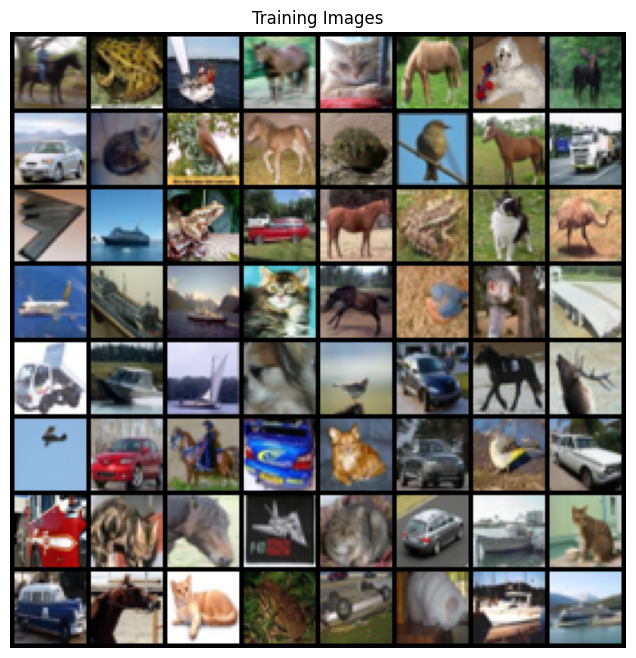

In [4]:
# Get some random training images
dataiter = iter(dataloader)
images, labels = next(dataiter)

# Show images
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(images[:64], padding=2, normalize=True).numpy(), (1, 2, 0)))

plt.show()

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is Z_DIM, going into a convolution
            nn.ConvTranspose2d(Z_DIM, G_HIDDEN * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 8),
            nn.ReLU(True),
            # State size: (G_HIDDEN * 8) x 4 x 4
            nn.ConvTranspose2d(G_HIDDEN * 8, G_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 4),
            nn.ReLU(True),
            # State size: (G_HIDDEN * 4) x 8 x 8
            nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 2),
            nn.ReLU(True),
            # State size: (G_HIDDEN * 2) x 16 x 16
            nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN),
            nn.ReLU(True),
            # State size: (G_HIDDEN) x 32 x 32
            nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, 4, 2, 1, bias=False),
            nn.Tanh()
            # Final state size: (IMAGE_CHANNEL) x 32 x 32
        )

    def forward(self, input):
        return self.main(input)


In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Assuming the input images are 32x32x3 (CIFAR-10)
            nn.Conv2d(IMAGE_CHANNEL, D_HIDDEN, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(D_HIDDEN * 2, D_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True),
           # Adjusting this layer to ensure it does not reduce the size below the kernel size
            nn.Conv2d(D_HIDDEN * 4, D_HIDDEN * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(D_HIDDEN * 4, 1, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
       return self.main(input).view(-1, 1).squeeze(1)

In [9]:
# Create the generator
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

# Create the discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

viz_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)
fake = netG(viz_noise)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [10]:
# Initialize BCELoss function
criterion = nn.MSELoss()

# Setup Adam optimizers for both G and D ##first try
# Setup RMSprop optimizers for both G and D ## second try
#third  try
d_optimizer = optim.RMSprop(netD.parameters(), lr=lr)
g_optimizer = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

In [11]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(EPOCH_NUM):
    for i, data in enumerate(dataloader, 0):
        # Update discriminator with real data
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)  # Original code, now redundant
        label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)  # Original code, now redundant
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Update discriminator with fake data
        noise = torch.randn(b_size, Z_DIM, 1, 1, device=device)  # Use adjusted b_size for consistency
        fake = netG(noise)
        # label.fill_(FAKE_LABEL)  # Redundant due to label recreation below
        output = netD(fake.detach()).view(-1)
        b_size = output.size(0)  # Adjust b_size based on this model output as well
        label = torch.full((b_size,), FAKE_LABEL, dtype=torch.float, device=device)  # Recreate label with correct size
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        d_optimizer.step()

        # Update generator
        netG.zero_grad()
        # No need to adjust b_size here as it's already correct from the discriminator's last output
        label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)  # Ensure label is recreated with correct size
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        g_optimizer.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCH_NUM, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == EPOCH_NUM-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(viz_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

Starting Training Loop...
[0/5][0/391]	Loss_D: 0.5050	Loss_G: 0.2715	D(x): 0.5046	D(G(z)): 0.5044 / 0.4871
[0/5][50/391]	Loss_D: 0.3916	Loss_G: 0.3726	D(x): 0.5251	D(G(z)): 0.3502 / 0.3961
[0/5][100/391]	Loss_D: 0.3599	Loss_G: 0.4930	D(x): 0.6132	D(G(z)): 0.3287 / 0.3018
[0/5][150/391]	Loss_D: 0.2392	Loss_G: 0.6552	D(x): 0.6721	D(G(z)): 0.2345 / 0.1952
[0/5][200/391]	Loss_D: 0.1703	Loss_G: 0.7028	D(x): 0.7071	D(G(z)): 0.1672 / 0.1637
[0/5][250/391]	Loss_D: 0.2462	Loss_G: 0.7139	D(x): 0.6600	D(G(z)): 0.1735 / 0.1586
[0/5][300/391]	Loss_D: 0.1098	Loss_G: 0.7568	D(x): 0.7956	D(G(z)): 0.1337 / 0.1307
[0/5][350/391]	Loss_D: 0.0863	Loss_G: 0.7892	D(x): 0.8140	D(G(z)): 0.1204 / 0.1128
[1/5][0/391]	Loss_D: 0.1662	Loss_G: 0.7737	D(x): 0.8249	D(G(z)): 0.2744 / 0.1254
[1/5][50/391]	Loss_D: 0.0823	Loss_G: 0.8411	D(x): 0.8376	D(G(z)): 0.0903 / 0.0837
[1/5][100/391]	Loss_D: 0.0827	Loss_G: 0.8565	D(x): 0.8384	D(G(z)): 0.0836 / 0.0751
[1/5][150/391]	Loss_D: 0.0549	Loss_G: 0.8838	D(x): 0.8727	D(G(z)): 

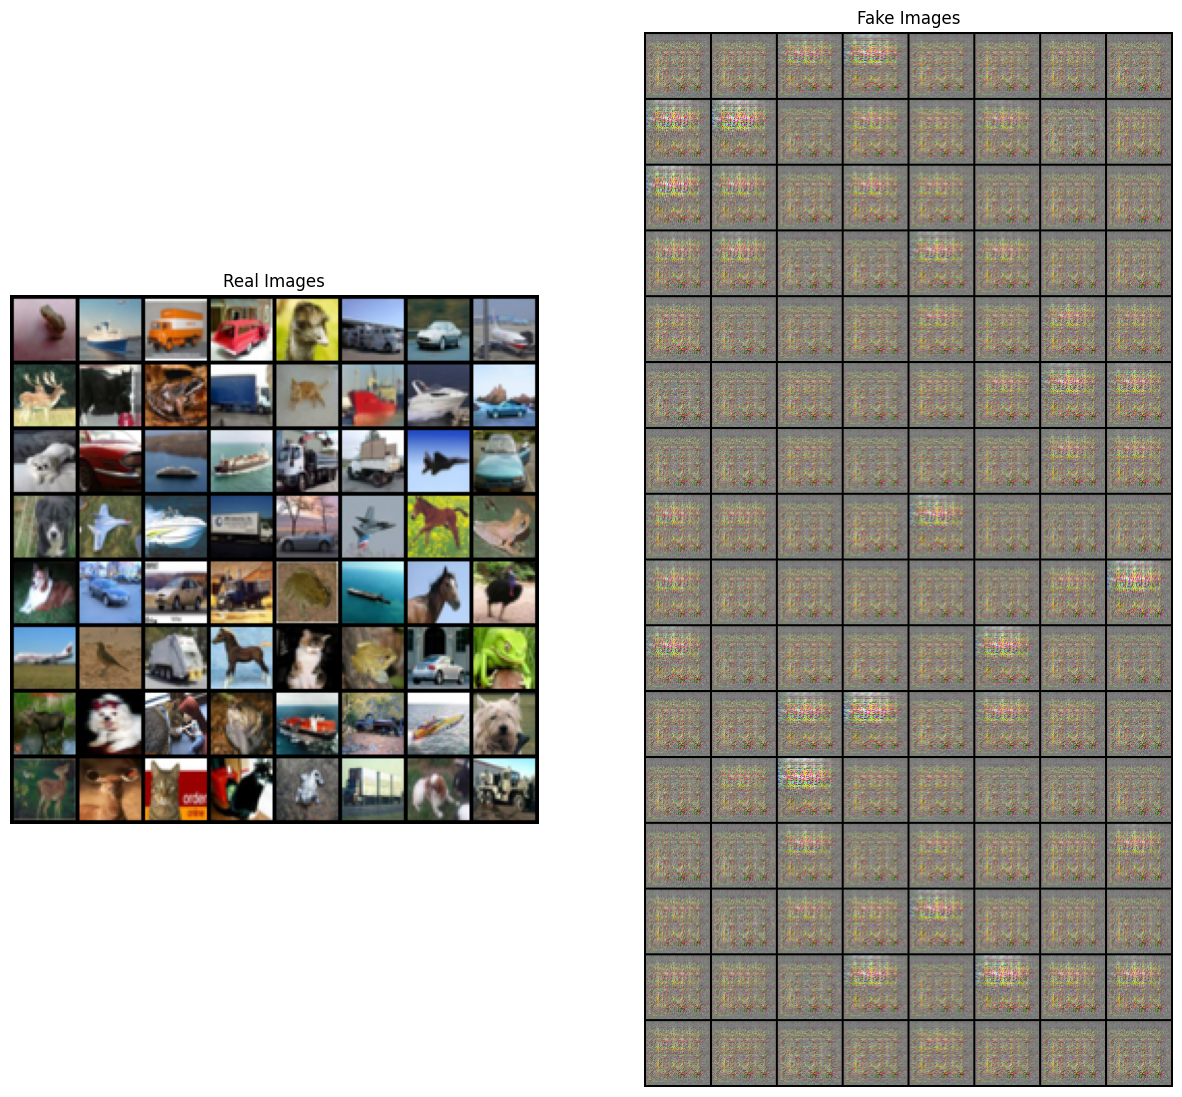

In [ ]:

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

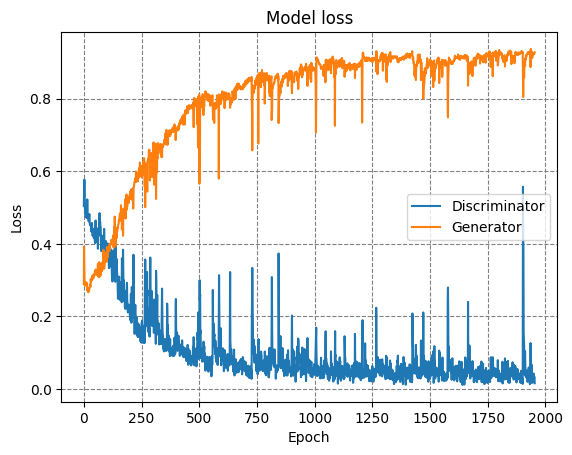

In [ ]:
# plotting the metrics
plt.plot(D_losses)
plt.plot(G_losses)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Generator'], loc='center right')
plt.grid(linestyle='--', color='gray')
plt.show()